<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Разработка-признаков-и-подготовка-данных" data-toc-modified-id="Разработка-признаков-и-подготовка-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Разработка признаков и подготовка данных</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Базовый-пайплайн" data-toc-modified-id="Базовый-пайплайн-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Базовый пайплайн</a></span></li><li><span><a href="#Собственная-метрика-для-оценки-моделей" data-toc-modified-id="Собственная-метрика-для-оценки-моделей-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Собственная метрика для оценки моделей</a></span></li><li><span><a href="#Параметры-моделей-для-решетчатого-поиска" data-toc-modified-id="Параметры-моделей-для-решетчатого-поиска-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Параметры моделей для решетчатого поиска</a></span></li><li><span><a href="#Поиск-и-оценка-моделей" data-toc-modified-id="Поиск-и-оценка-моделей-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Поиск и оценка моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
    OrdinalEncoder,
)
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


RANDOM_STATE = 42
TEST_SIZE = 0.1

## Подготовка

In [3]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
df = df.sort_index()

In [5]:
df = df.resample('1H').sum()

## Анализ

In [6]:
min_dt = df.index.min().strftime('%d.%m.%Y')
max_dt = df.index.max().strftime('%d.%m.%Y')

print(f'''Мы располашаем данными с {min_dt} по {max_dt}''')

Мы располашаем данными с 01.03.2018 по 31.08.2018


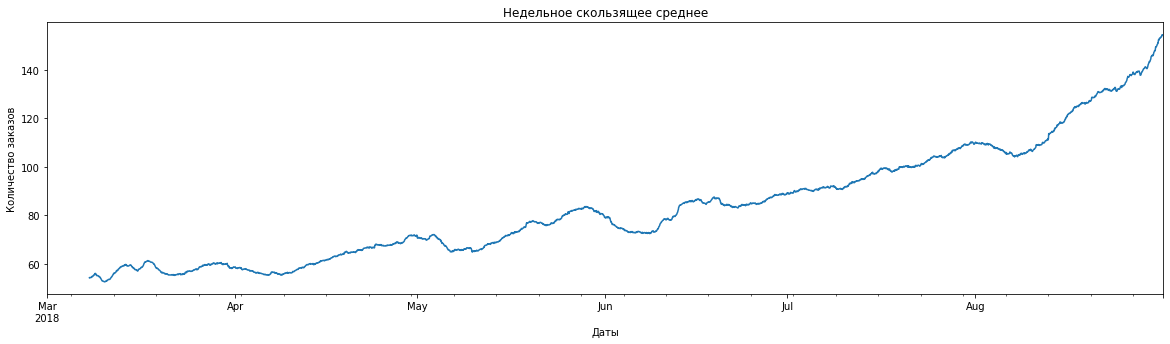

In [7]:
df.rolling(24 * 7).mean().plot(figsize=(20, 5), legend=False)
plt.title('Недельное скользящее среднее')
plt.xlabel('Даты')
plt.ylabel('Количество заказов')
plt.show()

Мы видим, что с течением времени количество заказов растёт. Проверим дневные тренд и сезонную составляющую.

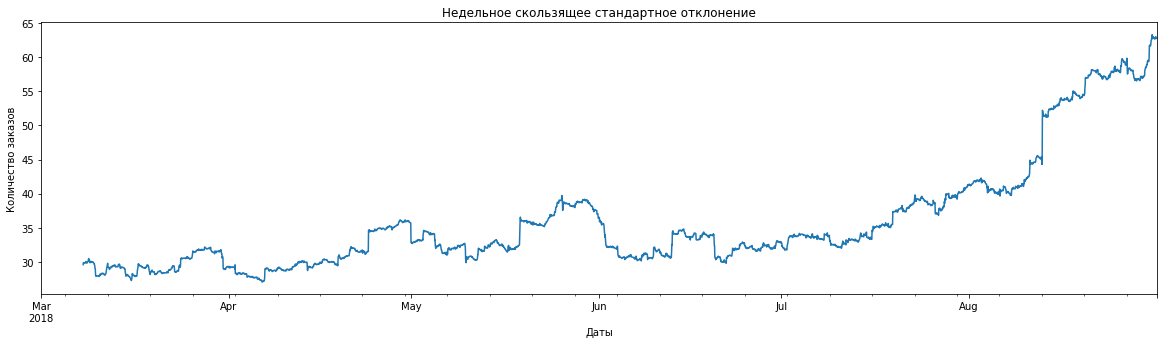

In [8]:
df.rolling(24 * 7).std().plot(figsize=(20, 5), legend=False)
plt.title('Недельное скользящее стандартное отклонение')
plt.xlabel('Даты')
plt.ylabel('Количество заказов')
plt.show()

Также мы можем видеть некий перелом в августе, когда стандартное отклонение совершило резкий скачок и продолжило расти.

In [9]:
decomposed = seasonal_decompose(df)

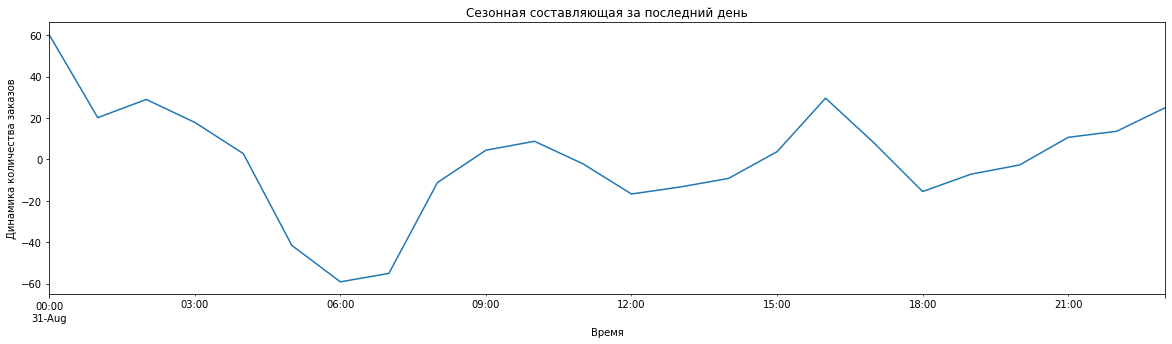

In [10]:
decomposed.seasonal['2018-08-31'].plot(figsize=(20, 5))
plt.title('Сезонная составляющая за последний день')
plt.xlabel('Время')
plt.ylabel('Динамика количества заказов')
plt.show()

Видно, что в 6:00 пассажиропоток минимален. Существует несколько пиков - ближе к началу и к концу рабочего дня. Также крайне высокие значения наблюдаются ближе к полуночи.

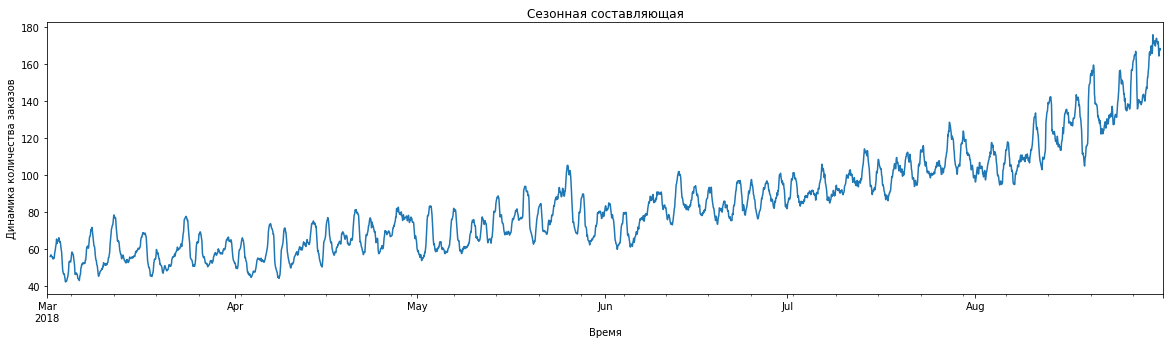

In [11]:
decomposed.trend.plot(figsize=(20, 5))
plt.title('Сезонная составляющая')
plt.xlabel('Время')
plt.ylabel('Динамика количества заказов')
plt.show()

Тренд подтверждает то, что мы уведели на скользящем среднем. Есть тенденция к повышению числа заказов со временем.

## Разработка признаков и подготовка данных

In [12]:
def make_features(data, max_lag):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['week'] = data.index.isocalendar().week

    # Целевая метрика
    data['orders_next_hour'] = data['num_orders'].shift(-1)

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean_day'] = data['num_orders'].shift().rolling(24).mean()
    data['rolling_mean_week'] = data['num_orders'].shift().rolling(168).mean()


make_features(df, 10)

train, test = train_test_split(df, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()
test = test.dropna()

In [13]:
X_train = train.drop('orders_next_hour', axis=1)
y_train = train['orders_next_hour']

X_test = test.drop('orders_next_hour', axis=1)
y_test = test['orders_next_hour']

## Обучение

### Базовый пайплайн

In [14]:
X_train

,num_orders,hour,day,dayofweek,week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean_day,rolling_mean_week
datetime,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,8,3,10,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,60.041667,54.226190
2018-03-08 01:00:00,78,1,8,3,10,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,61.833333,54.339286
2018-03-08 02:00:00,65,2,8,3,10,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,60.041667,54.297619
2018-03-08 03:00:00,68,3,8,3,10,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,61.750000,54.261905
2018-03-08 04:00:00,60,4,8,3,10,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,61.833333,54.273810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,137,9,13,0,33,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,185.0,134.041667,113.821429
2018-08-13 10:00:00,156,10,13,0,33,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,135.250000,113.827381
2018-08-13 11:00:00,144,11,13,0,33,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,137.250000,114.017857


In [15]:
num_cols = [
    'num_orders',
    'lag_1',
    'lag_2',
    'lag_3',
    'lag_4',
    'lag_5',
    'lag_6',
    'lag_7',
    'lag_8',
    'lag_9',
    'lag_10',
    'rolling_mean_day',
    'rolling_mean_week',
]
cat_cols = ['hour', 'day', 'dayofweek', 'week']

data_preprocessor = ColumnTransformer(
    # Пайплайн обработки
    [
        ('num', StandardScaler(), num_cols),
        (
            'cat',
            OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=-1
            ),
            cat_cols,
        ),
    ],
    remainder='passthrough',
)

pipe_final = Pipeline(
    # Финальный пайплайн
    [
        ('preprocessor', data_preprocessor),
        ('model', DecisionTreeRegressor(random_state=RANDOM_STATE)),
    ]
)

### Собственная метрика для оценки моделей

In [16]:
def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)

    distance = predict - actual

    square_distance = distance**2

    mean_square_distance = square_distance.mean()

    score = np.sqrt(mean_square_distance)

    return score


rmse_score = make_scorer(rmse, greater_is_better=False)

### Параметры моделей для решетчатого поиска

In [17]:
# Параметры логистической регрессии
lin_params = {}

lin_params['preprocessor__num'] = [
    StandardScaler(),
    MinMaxScaler(),
    RobustScaler(),
]
lin_params['preprocessor__cat'] = [OneHotEncoder(drop='first')]

lin_params['model'] = [LinearRegression()]

In [18]:
# Параметры для KNeighborsRegressor
knn_params = {}

knn_params['preprocessor__num'] = [
    StandardScaler(),
    MinMaxScaler(),
    RobustScaler(),
]

knn_params['model__n_neighbors'] = [2, 5]
knn_params['model'] = [KNeighborsRegressor()]

In [19]:
# Параметры для DecisionTreeRegressor
tree_params = {}

tree_params['preprocessor__num'] = [RobustScaler()]

tree_params['model__max_depth'] = range(1, 2)
tree_params['model__min_samples_leaf'] = range(14, 15)
tree_params['model'] = [DecisionTreeRegressor(random_state=RANDOM_STATE)]

In [20]:
# Параметры для SVR
svr_params = {}

svr_params['preprocessor__num'] = [StandardScaler(), MinMaxScaler()]

svr_params['model__C'] = [10**-2, 10**-1]
svr_params['model'] = [SVR()]

In [21]:
# Параметры для SVR
lgbm_params = {}

lgbm_params['model'] = [lgb.LGBMRegressor()]

In [22]:
params = [svr_params, tree_params, knn_params, lin_params, lgbm_params]

### Поиск и оценка моделей 

In [23]:
grid_reg = GridSearchCV(
    pipe_final, params, cv=5, n_jobs=-1, scoring=rmse_score
)

In [24]:
grid_reg.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:988: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 977, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/_response.py", line 238, in _get_response_values
    y_pred, pos_label = prediction_m

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['num_orders',
                                                                          'lag_1',
                                                                          'lag_2',
                                                                          'lag_3',
                                                                          'lag_4',
                                                                          'lag_5',
                                                                          'lag_6',
                                                                          'lag_7',
                                                                          'lag_8',
                                                                          'lag_9',
                                                                          'lag_10',
                                                                          'rolling_mean_day',
                                                                          'rolling_mean_week']),
                                                                        ('cat',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1)...
                          'model__n_neighbors': [2, 5],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                RobustScaler()]},
                         {'model': [LinearRegression()],
                          'preprocessor__cat': [OneHotEncoder(drop='first')],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                RobustScaler()]},
                         {'model': [LGBMRegressor()]}],
             scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'))

In [25]:
results_df_reg = pd.DataFrame(grid_reg.cv_results_)
results_df_reg = results_df_reg.sort_values(by=["rank_test_score"])
results_df_reg = results_df_reg.set_index(
    results_df_reg["params"].apply(
        lambda x: "_".join(str(val) for val in x.values())
    )
).rename_axis("kernel")
results_df_reg['mean_test_score'] *= -1
results_df_reg[
    ["params", "rank_test_score", "mean_test_score", "std_test_score"]
].head()

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
LGBMRegressor(),{'model': LGBMRegressor()},1,24.689781,6.175852
KNeighborsRegressor()_5_StandardScaler(),"{'model': KNeighborsRegressor(), 'model__n_nei...",2,35.399084,11.505489
KNeighborsRegressor()_5_RobustScaler(),"{'model': KNeighborsRegressor(), 'model__n_nei...",3,35.587276,11.648978
DecisionTreeRegressor(random_state=42)_1_14_RobustScaler(),{'model': DecisionTreeRegressor(random_state=4...,4,35.611037,6.389465
KNeighborsRegressor()_5_MinMaxScaler(),"{'model': KNeighborsRegressor(), 'model__n_nei...",5,36.903651,12.652100


## Тестирование

In [26]:
best_model = grid_reg.best_estimator_.steps[1][1]
data_preprocessor.fit(X_train)
X_test_prepared = data_preprocessor.transform(X_test)

In [27]:
X_pred_test = best_model.predict(X_test_prepared)

rmse(X_pred_test, y_test)

43.71907073626491

In [28]:
test_plot_data = pd.DataFrame(y_test).copy()
test_plot_data['prediced_orders'] = X_pred_test

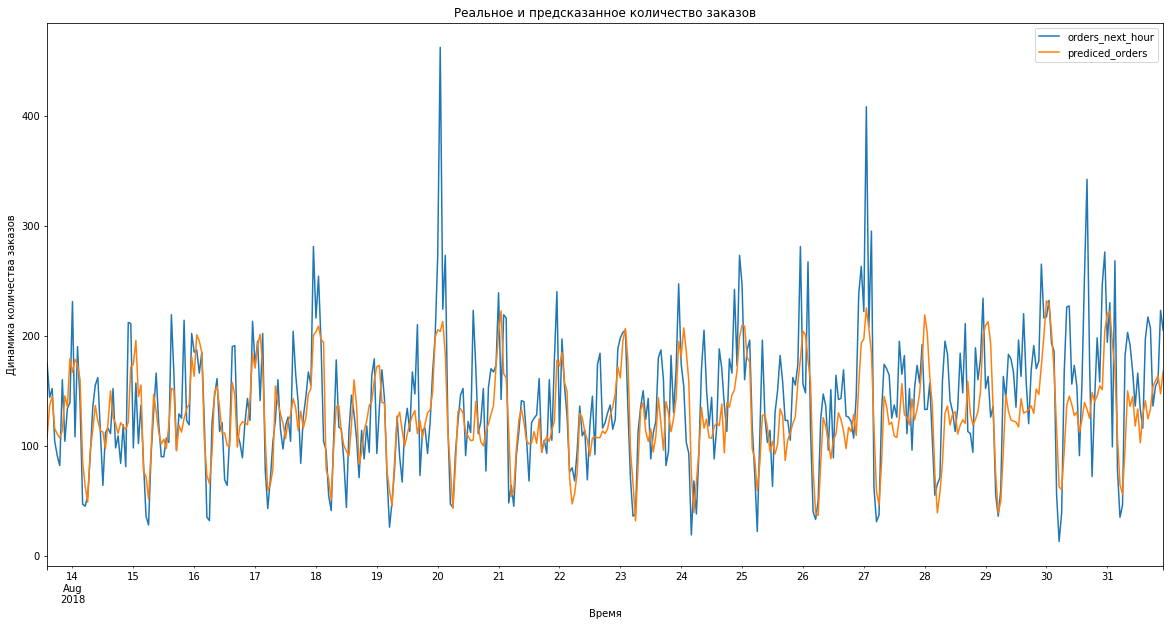

In [29]:
test_plot_data.plot(figsize=(20, 10))
plt.title('Реальное и предсказанное количество заказов')
plt.xlabel('Время')
plt.ylabel('Динамика количества заказов')
plt.show()

## Общий вывод

**Перед нами стояла задача:**

- Разработать модель, которая бы предсказывала нагруженность службы такси в следующий час;

**Что мы сделали:**

- Загрузили и обработали данные: выделили временной индекс, отсортировали и выделили семплы в 1 час;
- Провели исследовательский анализ данных: посмотрели на тренд и сезонную составляющую;
- Создали новые признаки, которые помогут в прогнозировании;
- Создали пайплайн, который обрабатывает количественные переменные и обучает модель;
- Протестировали несколько моделей, оценив время выполнения и RMSE;

**Результат:**
- Нам удалось снизить RMSE до приемлемого качества RMSE = 43;
- В ходе исследования нам удалось выяснить, что наболее значимый эффект оказывают правильно подобранные признаки. При верных признаках любая модель справляется с данными хорошо, а при их отсутствии - любая модель справляется плохо;
- В данном случае лучше всего себя показал градиентный бустинг с гиперпараметрами по умолчанию;